In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from typing import Iterable

# HookedTransformer

* [TransformerLens - Tutorial - Trains HookedTransformer from Scratch](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/No_Position_Experiment.ipynb)

```python
import transformers

# note: it's probably easier to just operate on tokens outside of the model,
#       that'll also make it clearer where tokenizer is used
#
# okay wrapping a pretrained tokenizer *can* be done:
# - https://huggingface.co/learn/nlp-course/chapter6/8#building-a-bpe-tokenizer-from-scratch
# - but none of the models support just naive encoding
#   - https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.BPE
class HookedTransformer:
    cfg: HookedTransformerConfig

    # note: actually does an `isinstance` check in the constructor
    tokenizer: transformers.PreTrainedTokenizerBase | None
```

In [3]:
import transformer_lens

from jaxtyping import Int64, Float32

import numpy as np
import plotly.express as px
import plotly.io as pio

import torch
import torch.utils.data

In [4]:
# plotting code copied over from transformer_lens tutorial notebook

def line(tensor: torch.Tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor: torch.Tensor, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

In [5]:
device = transformer_lens.utils.get_device()

print(f'Using device: {device}')

Using device: mps


### Setup Sample Generator

In [6]:
import string
import itertools
import more_itertools

class SpecialToken:
    # note: as assume a BOS token because transformerlens expects it
    BOS = '<'
    # we use a EOS token for convenience
    EOS = '>'

# TODO(bschoen): Allow this to generalize in the future
def generate_sample() -> Iterable[str]:
    """Generate palindrom samples like `<abc|cba>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    length = 3
    
    for combination in itertools.product(characters, repeat=length):

        combination_str = ''.join(combination)
        reversed_str = ''.join(reversed(combination_str))

        yield SpecialToken.BOS + combination_str + '|' + reversed_str + SpecialToken.EOS

# show a few examples
[x for x in more_itertools.take(10, generate_sample())]

['<aaa|aaa>',
 '<aab|baa>',
 '<aac|caa>',
 '<aad|daa>',
 '<aae|eaa>',
 '<aaf|faa>',
 '<aag|gaa>',
 '<aah|haa>',
 '<aai|iaa>',
 '<aaj|jaa>']

### Setup Tokenizer

In [7]:
from gpt_from_scratch.naive_tokenizer import NaiveTokenizer

vocab = string.ascii_lowercase + '|' + SpecialToken.BOS + SpecialToken.EOS

tokenizer = NaiveTokenizer.from_text(vocab)

In [8]:
from gpt_from_scratch import tokenizer_utils

# test tokenizer
input_text = '<abc|cba><bdd|ddb>'
tokenizer_utils.show_token_mapping(tokenizer, input_text)

Input:		<abc|cba><bdd|ddb>
Tokenized:	<abc|cba><bdd|ddb>
Token ID | Token Bytes | Token String
---------+-------------+--------------
       0 | 3C | '<'
          <abc|cba><bdd|ddb>
          U+003C LESS-THAN SIGN (1 bytes: 3C)
       2 | 61 | 'a'
          <abc|cba><bdd|ddb>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       3 | 62 | 'b'
          <abc|cba><bdd|ddb>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       4 | 63 | 'c'
          <abc|cba><bdd|ddb>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
      28 | 7C | '|'
          <abc|cba><bdd|ddb>
          U+007C VERTICAL LINE (1 bytes: 7C)
       4 | 63 | 'c'
          <abc|cba><bdd|ddb>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
       3 | 62 | 'b'
          <abc|cba><bdd|ddb>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       2 | 61 | 'a'
          <abc|cba><bdd|ddb>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       1 | 3E | '>'
          <abc|cba><bdd|ddb>
          U+003E GREAT

### Setup Model

In [183]:
# now we know our vocab size from our sample generation

cfg = transformer_lens.HookedTransformerConfig(
    n_layers=1,
    d_model=14,
    d_head=4,
    # The number of attention heads.
    # If not specified, will be set to d_in // d_head.
    # (This is represented by a default value of -1)
    n_heads=3,
    # The dimensionality of the feedforward mlp network.
    # Defaults to 4 * d_in, and in an attn-only model is None.
    # d_mlp=16,
    # note: transformerlens does the same thing if this is not set
    d_vocab=len(tokenizer.byte_to_token_dict),
    # length of the first sample is our context length
    n_ctx=len(more_itertools.nth(generate_sample(), 1)),
    act_fn="relu",
    normalization_type="LN",
    # note: must be set, otherwise tries to default to cuda / cpu (not mps)
    device=device.type,
)

print(f'Num params: {cfg.n_params}')

cfg

Num params: 2240


HookedTransformerConfig:
{'act_fn': 'relu',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 2.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 4,
 'd_mlp': 56,
 'd_model': 14,
 'd_vocab': 29,
 'd_vocab_out': 29,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': 'mps',
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': True,
 'initializer_range': 0.2138089935299395,
 'load_in_4bit': False,
 'model_name': 'custom',
 'n_ctx': 9,
 'n_devices': 1,
 'n_heads': 3,
 'n_key_value_heads': None,
 'n_layers': 1,
 'n_params': 2240,
 'normalization_type': 'LN',
 'num_experts': None,
 'original_architecture': None,
 'output_logits_soft_cap': -1.0,
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'post_embedding_ln'

### Setup Loss Function

In [184]:
def loss_fn(logits, target):
    # standard cross entropy loss
    return torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target.view(-1),
    )

### Evaluate On Test

In [186]:
def evaluate_loss_on_test_batches(
    model: transformer_lens.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
) -> float:

    # Set the model to evaluation mode
    model.eval()  

    losses = []

    with torch.no_grad():  # Disable gradient computation
        
        for batch in data_loader:
            
            x, y = batch

            x, y = x.to(device), y.to(device)

            logits = model(x)

            loss = loss_fn(logits, y)

            losses.append(loss.item())

    # Set the model back to training mode
    model.train() 

    return sum(losses) / len(losses)

### Setup Data Loaders

In [187]:
class AutoregressiveDataset(torch.utils.data.Dataset):
    def __init__(self, samples: list[str], tokenizer: NaiveTokenizer) -> None:
        self.samples = samples
        self.tokenizer = tokenizer  # Assuming tokenizer is defined in the global scope

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        tokens = self.tokenizer.encode(sample)
        
        # Convert to tensor and add batch dimension
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)
        
        return x, y

def make_batch_dataloader(
    samples: list[str],
    tokenizer: NaiveTokenizer,
    batch_size: int,
) -> tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader]:

    dataset = AutoregressiveDataset(samples=samples, tokenizer=tokenizer)
    
    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        # drop the last batch if it's incomplete
        drop_last=True,
    )
    
    return dataset, dataloader

# Example usage:
# batch_generator = make_batch_generator(tokenizer, batch_size=4)
# for x, y in batch_generator:
#     # x is input, y is target (x shifted by 1)
#     pass


In [188]:
# split into test and train
all_samples = list(generate_sample())

# note: 4394 batches = (26 * 26 * 26) / 4
print(f'{len(all_samples)} samples')

# max_samples = 10
# print(f'Capping at {max_samples} batches first to make sure we can overfit')
# all_samples = all_samples[:max_samples]

test_train_ratio = 0.1

test_size = int(test_train_ratio * len(all_samples))
    
# put remaining ones into train
train_size = len(all_samples) - test_size

train_samples = all_samples[:train_size]
test_samples = all_samples[train_size:]

print(f'{len(train_samples)=}')
print(f'{len(test_samples)=}')

# now we can finally construct dataloaders
batch_size = 4

train_dataset, train_loader = make_batch_dataloader(
    samples=train_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)
test_dataset, test_loader = make_batch_dataloader(
    samples=test_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)


17576 samples
len(train_samples)=15819
len(test_samples)=1757


### Training

In [189]:
import tqdm

import torch.optim

import wandb

# TODO(bschoen): Try out optuna wrapper for this


# create new model instance
model = transformer_lens.HookedTransformer(cfg)

# setup optimizers
lr = 1e-4
betas = (0.9, 0.95)
max_grad_norm = 1.0
wd = 0.1

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / 100, 1.0))

num_epochs = 100000

# setup wandb
config = cfg.to_dict()
config.update({
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'lr': 1e-4,
    'max_grad_norm': 1.0,
    'wd': 0.1,
})
wandb.init(
    project="toy-problem-hooked-transformer",
    config=config,
)

losses = []
test_losses = []

for epoch, batch in tqdm.tqdm(
    zip(
        range(num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # ex: torch.Size([4, 9, 29])
    logits: Float32[torch.Tensor, "batch_size n_ctx d_vocab"] = model(tokens)

    # print(f"Logits:\n{logits.shape}")
    loss = loss_fn(logits, target)

    loss.backward()

    if max_grad_norm is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

    optimizer.step()

    optimizer.zero_grad()

    scheduler.step()

    losses.append(loss.item())

    # TODO(bschoen): Shouldn't you actually divide loss by batch size?
    if epoch % 500 == 0:
        print('Evaluating test loss')

        test_loss = evaluate_loss_on_test_batches(model, test_loader)

        test_losses.append(test_loss)

        print(f"Epoch {epoch}: Train loss: {loss.item():.6f}, Test loss: {test_loss:.6f}")

        wandb.log({
            'epoch': epoch,
            'train_loss': loss.item(),
            'test_loss': test_loss,
        })

wandb.finish()

# log locally to sanity check
px.line(losses, labels={"x": "Epoch", "y": "Train Loss"})


0it [00:00, ?it/s]

Evaluating test loss


6it [00:04,  1.85it/s]

Epoch 0: Train loss: 3.385458, Test loss: 3.388856


499it [00:09, 88.44it/s]

Evaluating test loss


516it [00:11, 22.71it/s]

Epoch 500: Train loss: 3.093160, Test loss: 3.032280


997it [00:17, 85.38it/s]

Evaluating test loss


1014it [00:18, 21.88it/s]

Epoch 1000: Train loss: 2.723905, Test loss: 2.852489


1500it [00:24, 87.91it/s]

Evaluating test loss


1509it [00:25, 17.76it/s]

Epoch 1500: Train loss: 2.539069, Test loss: 2.716844


1995it [00:31, 87.13it/s]

Evaluating test loss


2012it [00:32, 22.37it/s]

Epoch 2000: Train loss: 2.380469, Test loss: 2.611388


2498it [00:38, 87.12it/s]

Evaluating test loss


2515it [00:40, 22.27it/s]

Epoch 2500: Train loss: 2.411690, Test loss: 2.521791


2992it [00:45, 86.53it/s]

Evaluating test loss


3008it [00:47, 21.65it/s]

Epoch 3000: Train loss: 2.294732, Test loss: 2.459525


3298it [00:50, 65.23it/s]


KeyboardInterrupt: 

In [82]:
# Look at some example output
import circuitsvis as cv

# create a custom to_string function since using our own tokenizer
def token_to_string(token: int) -> str:
    return tokenizer.decode([token])

# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

example_sample = x[0]

# grab the first part of it, ex: `<abc|`
example_prompt = example_sample # [:8]

example_prompt = example_prompt.to(device)

print(f'Using {example_prompt} from {example_sample} (from test set)')

# note: already encoded
input_tokens = example_prompt

logits_batch, cache = model.run_with_cache(input_tokens)

logits = logits_batch[0]

log_probs = logits.log_softmax(dim=-1)

cv.logits.token_log_probs(
    token_indices=input_tokens,
    log_probs=log_probs,
    to_string=token_to_string,
)
 

Using tensor([ 0, 25, 16, 20, 28, 20, 16, 25], device='mps:0') from tensor([ 0, 25, 16, 20, 28, 20, 16, 25]) (from test set)


### Looking at it with CircuitsViz

In [83]:
# before even going to SAE, let's look at circuitsviz here
import circuitsvis as cv

import circuitsvis.activations
import circuitsvis.attention
import circuitsvis.logits
import circuitsvis.tokens
import circuitsvis.topk_samples
import circuitsvis.topk_tokens

In [84]:
# first let's see what we have
import tabulate

print(f'{len(input_tokens)=}')

# show the first few elements of the `HookedTransformerConfig`, since that has things like `d_model`, num heads, etc
print(tabulate.tabulate([(k, v) for k, v in cfg.__dict__.items()][:10]))

print(tabulate.tabulate([(k, v.shape) for k, v in cache.items()]))

len(input_tokens)=8
----------  ------
n_layers    1
d_model     16
n_ctx       9
d_head      4
model_name  custom
n_heads     4
d_mlp       64
act_fn      relu
d_vocab     29
eps         1e-05
----------  ------
------------------------------  ------------------------
hook_embed                      torch.Size([1, 8, 16])
hook_pos_embed                  torch.Size([1, 8, 16])
blocks.0.hook_resid_pre         torch.Size([1, 8, 16])
blocks.0.ln1.hook_scale         torch.Size([1, 8, 1])
blocks.0.ln1.hook_normalized    torch.Size([1, 8, 16])
blocks.0.attn.hook_q            torch.Size([1, 8, 4, 4])
blocks.0.attn.hook_k            torch.Size([1, 8, 4, 4])
blocks.0.attn.hook_v            torch.Size([1, 8, 4, 4])
blocks.0.attn.hook_attn_scores  torch.Size([1, 4, 8, 8])
blocks.0.attn.hook_pattern      torch.Size([1, 4, 8, 8])
blocks.0.attn.hook_z            torch.Size([1, 8, 4, 4])
blocks.0.hook_attn_out          torch.Size([1, 8, 16])
blocks.0.hook_resid_mid         torch.Size([1, 8, 16])
bloc

#### circuitsvis.activations

In [85]:
# tokens := List of tokens if single sample (e.g. `["A", "person"]`) or list of lists of tokens (e.g. `[[["A", "person"], ["is", "walking"]]]`)
# activations := Activations of the shape [tokens x layers x neurons] if single sample or list of [tokens x layers x neurons] if multiple samples

# take first batch for now
activations = cache['blocks.0.hook_mlp_out'][0]
print(f'{activations.shape=}')

# reshape [tokens x neurons] -> [tokens x 1 x neurons]
#  - `-1` means to automatically infer the size of the last dimension
activations_view = activations.view(len(input_tokens), cfg.n_layers, -1)

print(f'{activations_view.shape=}')

# convert to strings (which this function expects)
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

# TODO(bschoen): Is there a way to essentially stack these? Claude can probably give the React for that

# so here we can visualize activations for a `torch.Size([1, 8, 16])`, which is most
# of them since this is the size of the embedding dimension
circuitsvis.activations.text_neuron_activations(
    tokens=[token_to_string(x.item()) for x in input_tokens],
    activations=activations_view,
)

activations.shape=torch.Size([8, 16])
activations_view.shape=torch.Size([8, 1, 16])


#### circuitsvis.attention

In [44]:
# note `attention_pattern` and `attention_patterns` are deprecated in favor of `attention_heads`
circuitsvis.attention.attention_heads?

Signature:
circuitsvis.attention.attention_heads(
    attention: Union[list, numpy.ndarray, torch.Tensor],
    tokens: List[str],
    attention_head_names: Optional[List[str]] = None,
    max_value: Optional[float] = None,
    min_value: Optional[float] = None,
    negative_color: Optional[str] = None,
    positive_color: Optional[str] = None,
    mask_upper_tri: Optional[bool] = None,
) -> circuitsvis.utils.render.RenderedHTML
Docstring:
Attention Heads

Attention patterns from destination to source tokens, for a group of heads.

Displays a small heatmap for each attention head. When one is selected, it
is then shown in full size.

Args:
    attention: Attention head activations of the shape [dest_tokens x
    src_tokens]
    tokens: List of tokens (e.g. `["A", "person"]`). Must be the same length
    as the list of values.
    max_value: Maximum value. Used to determine how dark the token color is
    when positive (i.e. based on how close it is to the maximum value).
    min_value: 

In [64]:
# tokens: List of tokens (e.g. `["A", "person"]`). Must be the same length as the list of values.
# attention: Attention head activations of the shape [dest_tokens x src_tokens]
# max_value: Maximum value. Used to determine how dark the token color is when positive (i.e. based on how close it is to the maximum value).
# min_value: Minimum value. Used to determine how dark the token color is when negative (i.e. based on how close it is to the minimum value).
# negative_color: Color for negative values
# positive_color: Color for positive values.
#show_axis_labels: Whether to show axis labels.
# mask_upper_tri: Whether or not to mask the upper triangular portion of the attention patterns. Should be true for causal attention, false for bidirectional attention.



# take first batch
# ex: torch.Size([4, 8, 8]) -> [n_heads, n_ctx, n_ctx]
# note: `blocks.0.attn.hook_attn_scores` is too early (not normalized?)
attention = cache['blocks.0.attn.hook_pattern'][0]

print(f'{attention.shape=}')

circuitsvis.attention.attention_heads(
    tokens=input_tokens_as_strings,
    attention=attention,
    max_value=1,
    min_value=-1,
    negative_color='blue',
    positive_color='red',
    mask_upper_tri=True,
)

attention.shape=torch.Size([4, 8, 8])


#### circuitsvis.logits

In [66]:
# this is the normal one we usually show, i.e.
# cv.logits.token_log_probs(
#     token_indices=input_tokens,
#     log_probs=log_probs,
#     to_string=token_to_string,
# )

#### circuitsvis.tokens

In [94]:
# for example, we'll look at each 

# take first batch, ex: torch.Size([8, 16])
pos_embed = cache['hook_pos_embed'][0]

# low level function for coloring tokens according to single value
for i in range(cfg.d_model):
    display(circuitsvis.tokens.colored_tokens(
        tokens=input_tokens_as_strings,
        values=pos_embed[:, i],
        negative_color='blue',
        positive_color='red',
    ))

    # only display a few for example
    # if i >= 2:
    #    break


In [95]:
# take first batch
# ex: torch.size([8, 16]) = [n_ctx, d_model]
attention_out = cache['blocks.0.hook_attn_out'][0]

circuitsvis.tokens.colored_tokens_multi(
    tokens=input_tokens_as_strings,
    values=attention_out,
    labels=[str(x) for x in range(cfg.d_model)],
)

In [97]:
circuitsvis.tokens.visualize_model_performance(
    tokens=input_tokens,
    str_tokens=input_tokens_as_strings,
    logits=logits,
)

#### circuitsvis.topk_samples

In [98]:
circuitsvis.topk_samples.topk_samples??

Signature:
circuitsvis.topk_samples.topk_samples(
    tokens: List[List[List[List[str]]]],
    activations: List[List[List[List[float]]]],
    zeroth_dimension_name: Optional[str] = 'Layer',
    first_dimension_name: Optional[str] = 'Neuron',
    zeroth_dimension_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> circuitsvis.utils.render.RenderedHTML
Source:   
def topk_samples(
    tokens: List[List[List[List[str]]]],
    activations: List[List[List[List[float]]]],
    zeroth_dimension_name: Optional[str] = "Layer",
    first_dimension_name: Optional[str] = "Neuron",
    zeroth_dimension_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> RenderedHTML:
    """List of samples in descending order of max token activation value for the
    selected layer and neuron (or whatever other dimension names are specified).

    Args:
        tokens: List of tokens of shape [layers x neurons x samples x toke

#### circuitsvis.topk_tokens

In [99]:
circuitsvis.topk_tokens.topk_tokens??

Signature:
circuitsvis.topk_tokens.topk_tokens(
    tokens: List[List[str]],
    activations: List[numpy.ndarray],
    max_k: int = 10,
    first_dimension_name: str = 'Layer',
    third_dimension_name: str = 'Neuron',
    sample_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> circuitsvis.utils.render.RenderedHTML
Source:   
def topk_tokens(
    tokens: List[List[str]],
    activations: List[np.ndarray],  # np.ndarray: [n_layers, n_tokens, n_neurons]
    max_k: int = 10,
    first_dimension_name: str = "Layer",
    third_dimension_name: str = "Neuron",
    sample_labels: Optional[List[str]] = None,
    first_dimension_labels: Optional[List[str]] = None,
) -> RenderedHTML:
    """Show a table of the topk and bottomk activations.

    The columns correspond to the given third_dimension_name.

    Includes drop-downs for all dimensions as well as options to choose the number of columns to show.

    Note that we can't set labels for the thi

## SAE

In [ ]:
for layer_index in range(cfg.n_layers):
    imshow(
        transformer_lens.utils.to_numpy(cache["attn", layer_index].mean([0, 1])),
        title=f"Layer {layer_index} Attention Pattern",
        height=400,
        width=400,
    )

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dataclasses

Loss = Float32[torch.Tensor, ""]
MSELoss = Float32[torch.Tensor, ""]
WeightedSparsityLoss = Float32[torch.Tensor, ""]

Logits = Float32[torch.Tensor, "n_ctx d_vocab"]
BatchedLogits = Float32[torch.Tensor, "batch n_ctx d_vocab"]

ModelActivations = Float32[torch.Tensor, "n_ctx d_model"]
BatchedModelActivations = Float32[torch.Tensor, "batch n_ctx d_model"]

FlattenedModelActivations = Float32[torch.Tensor, "d_sae_in"]

BatchedFlattenedModelActivations = Float32[torch.Tensor, "batch d_sae_in"]
BatchedSAEActivations = Float32[torch.Tensor, "batch d_sae_model"]

@dataclasses.dataclass
class SAEOutput:
    sae_activations: BatchedSAEActivations
    reconstructed_model_activations: BatchedFlattenedModelActivations

def sparse_loss_kl_divergence(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_target: float,
    sparsity_weight: float,
    epsilon: float = 1e-7,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # same as dense loss (this is constant?)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    ) 
    
    # KL divergence for sparsity
    avg_activation = torch.mean(sae_output.sae_activations, dim=0)

    # print(f'[pre-clamping] {avg_activation=}')

    # Add epsilon for numerical stability
    avg_activation = torch.clamp(avg_activation, epsilon, 1 - epsilon)

    kl_div = sparsity_target * torch.log(sparsity_target / avg_activation) + \
             (1 - sparsity_target) * torch.log((1 - sparsity_target) / (1 - avg_activation))
    kl_div = torch.sum(kl_div)

    # `sparsity_weight` decides how much we weight `KL-Divergence`
    sparsity_penalty = sparsity_weight * kl_div

    print(f'[sparse_loss] {mse_loss=}, {avg_activation=}, {kl_div.item()}, {sparsity_penalty=}')
    
    return mse_loss + sparsity_penalty, mse_loss, sparsity_penalty

In [119]:
def sparse_loss_l1_norm(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_weight: float,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # Reconstruction loss (Mean Squared Error)
    mse_loss = F.mse_loss(sae_output.reconstructed_model_activations, flattened_model_activations,)
    
    # L1 sparsity penalty
    l1_penalty = torch.mean(torch.abs(sae_output.sae_activations))

    sparsity_penalty = sparsity_weight * l1_penalty
    
    # Total loss
    total_loss = mse_loss + sparsity_penalty
    
    return total_loss, mse_loss, sparsity_penalty

In [118]:
import dataclasses

@dataclasses.dataclass
class SparseAutoencoderConfig:
    d_in: int
    d_model: int

# TODO(bschoen): Start using the config pattern, it stays typesafe and allows
#                easy logging to things like wandb
class SparseAutoencoder(nn.Module):
    def __init__(
        self,
        cfg: SparseAutoencoderConfig,
    ) -> None:

        print(f'Creating SparseAutoencoder with {cfg}')

        super(SparseAutoencoder, self).__init__()

        self.d_in = cfg.d_in
        self.d_model = cfg.d_model

        self.encoder = nn.Linear(cfg.d_in, cfg.d_model)
        self.decoder = nn.Linear(cfg.d_model, cfg.d_in)

    
    def forward(
        self,
        x: BatchedFlattenedModelActivations,
    ) -> SAEOutput:
        
        # TODO(bschoen): Which activation function should we use?
        encoded = F.gelu(self.encoder(x))
        
        decoded = self.decoder(encoded)
        
        return SAEOutput(
            sae_activations=encoded,
            reconstructed_model_activations=decoded,
        )
   

In [115]:
import lightning.pytorch

@dataclasses.dataclass
class LightningSparseAutoencoderConfig:
    
    model_config: transformer_lens.HookedTransformerConfig
    sae_config: SparseAutoencoderConfig
    learning_rate: float
    sparsity_weight: float
    
# note: this kind of lightning adapter is a common pattern: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#starter-example
class LightningSparseAutoencoder(lightning.pytorch.LightningModule):
    def __init__(
        self,
        cfg: LightningSparseAutoencoderConfig,
    ) -> None:

        super(LightningSparseAutoencoder, self).__init__()
        
        self.model = transformer_lens.HookedTransformer(cfg=cfg.model_config)
        self.sae = SparseAutoencoder(cfg=cfg.sae_config)
        self.cfg = cfg

    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx: int) -> Loss:
        inputs, target = batch

        self.model
        output = self(inputs, target)
        loss = torch.nn.functional.cr(output, target.view(-1))
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [116]:
hook_id = 'blocks.0.hook_mlp_out'

cache[hook_id].shape

torch.Size([4, 8, 16])

In [122]:
# Training loop
sae_num_epochs = 100000
sae_expansion_factor = 4

learning_rate = 1e-4

# both arbitrary for now
# - Start small: A common approach is to begin with a relatively small sparsity weight, 
#                typically in the range of 1e-5 to 1e-3. This allows the model to
#                learn meaningful representations before enforcing strong sparsity
#                constraints.
sparsity_weight: float = 1e-3  # Weight of the sparsity loss in the total loss
sparsity_target: float = 0.05  # Target average activation of hidden neurons

print(f'Training SAE for {hook_id}...')
sae_d_in = (cfg.n_ctx - 1) * cfg.d_model  # -1 since not predicting first token
sae_d_model = sae_d_in * sae_expansion_factor

sae_cfg = SparseAutoencoderConfig(
    d_in=sae_d_in,
    d_model=sae_d_model,
)

sae_model = SparseAutoencoder(cfg=sae_cfg)
sae_model.to(device)

sae_optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

wandb.init(
    project="toy-problem-hooked-transformer-sae",
    config={
        'sae_num_epochs': sae_num_epochs,
        'sae_expansion_factor': sae_expansion_factor,
        'learning_rate': learning_rate,
        'sparsity_weight': sparsity_weight,
        'sparsity_target': sparsity_target,
        'sae_d_in': sae_d_in,
        'sae_d_model': sae_d_model,
        'hook_id': hook_id,
    },
)

# put model itself into eval mode so doesn't change
model.eval()

# go through the training data again, this time training the sae on the activations
for epoch, batch in tqdm.tqdm(
    zip(
        range(sae_num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run through the model (with cache) to get the activations
    logits, cache = model.run_with_cache(tokens)

    # ex: torch.Size([4, 8, 16])
    activations = cache[hook_id]

    # ex: torch.Size([4, 128])
    flattened_activations = activations.reshape(activations.size(0), -1)

    sae_optimizer.zero_grad()

    # now the SAE model is given the *activations*
    sae_output = sae_model.forward(flattened_activations)

    # compute loss

    #total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_kl_divergence(
    #    flattened_activations,
    #    sae_output,
    #    sparsity_target=sparsity_target,
    #    sparsity_weight=sparsity_weight,
    #)

    total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_l1_norm(
        flattened_model_activations=flattened_activations,
        sae_output=sae_output,
        sparsity_weight=sparsity_weight,
    )

    total_loss.backward()

    sae_optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Step {epoch}, "
            f"Total Loss: {total_loss.item():.6f}, "
            f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
            f"Sparsity Loss: {weighted_sparsity_loss.item():.6f}",
        )

        wandb.log({
            'epoch': epoch,
            'total_loss': total_loss.item(),
            'reconstruction_loss': reconstruction_loss.item(),
            'weighted_sparsity_loss': weighted_sparsity_loss.item(),
        })

wandb.finish()

Training SAE for blocks.0.hook_mlp_out...
Creating SparseAutoencoder with SparseAutoencoderConfig(d_in=128, d_model=512)


51it [00:00, 248.21it/s]

Step 0, Total Loss: 0.852148, Reconstruction Loss: 0.851933, Sparsity Loss: 0.000216


543it [00:02, 243.12it/s]

Step 500, Total Loss: 0.032719, Reconstruction Loss: 0.032324, Sparsity Loss: 0.000395


1035it [00:04, 253.07it/s]

Step 1000, Total Loss: 0.016778, Reconstruction Loss: 0.016274, Sparsity Loss: 0.000504


1536it [00:06, 243.23it/s]

Step 1500, Total Loss: 0.007943, Reconstruction Loss: 0.007383, Sparsity Loss: 0.000560


2043it [00:08, 253.14it/s]

Step 2000, Total Loss: 0.005511, Reconstruction Loss: 0.004913, Sparsity Loss: 0.000598


2531it [00:10, 171.67it/s]

Step 2500, Total Loss: 0.004258, Reconstruction Loss: 0.003620, Sparsity Loss: 0.000638


3040it [00:13, 195.38it/s]

Step 3000, Total Loss: 0.003516, Reconstruction Loss: 0.002913, Sparsity Loss: 0.000604


3536it [00:15, 187.81it/s]

Step 3500, Total Loss: 0.002430, Reconstruction Loss: 0.001833, Sparsity Loss: 0.000597


4022it [00:18, 199.46it/s]

Step 4000, Total Loss: 0.002228, Reconstruction Loss: 0.001647, Sparsity Loss: 0.000581


4531it [00:20, 233.50it/s]

Step 4500, Total Loss: 0.002118, Reconstruction Loss: 0.001554, Sparsity Loss: 0.000564


5045it [00:22, 256.78it/s]

Step 5000, Total Loss: 0.002051, Reconstruction Loss: 0.001489, Sparsity Loss: 0.000562


5534it [00:24, 267.44it/s]

Step 5500, Total Loss: 0.001672, Reconstruction Loss: 0.001144, Sparsity Loss: 0.000528


6053it [00:26, 268.56it/s]

Step 6000, Total Loss: 0.001528, Reconstruction Loss: 0.001017, Sparsity Loss: 0.000510


6520it [00:28, 254.04it/s]

Step 6500, Total Loss: 0.001701, Reconstruction Loss: 0.001227, Sparsity Loss: 0.000474


7041it [00:30, 246.93it/s]

Step 7000, Total Loss: 0.001140, Reconstruction Loss: 0.000682, Sparsity Loss: 0.000459


7530it [00:32, 181.25it/s]

Step 7500, Total Loss: 0.001302, Reconstruction Loss: 0.000852, Sparsity Loss: 0.000450


8038it [00:34, 235.63it/s]

Step 8000, Total Loss: 0.001096, Reconstruction Loss: 0.000670, Sparsity Loss: 0.000426


8530it [00:36, 241.95it/s]

Step 8500, Total Loss: 0.001040, Reconstruction Loss: 0.000629, Sparsity Loss: 0.000411


9023it [00:38, 264.75it/s]

Step 9000, Total Loss: 0.001037, Reconstruction Loss: 0.000645, Sparsity Loss: 0.000392


9530it [00:41, 238.03it/s]

Step 9500, Total Loss: 0.001070, Reconstruction Loss: 0.000689, Sparsity Loss: 0.000381


10048it [00:43, 261.88it/s]

Step 10000, Total Loss: 0.000888, Reconstruction Loss: 0.000527, Sparsity Loss: 0.000361


10553it [00:45, 260.67it/s]

Step 10500, Total Loss: 0.000843, Reconstruction Loss: 0.000495, Sparsity Loss: 0.000348


11039it [00:47, 218.12it/s]

Step 11000, Total Loss: 0.000881, Reconstruction Loss: 0.000546, Sparsity Loss: 0.000335


11533it [00:49, 269.82it/s]

Step 11500, Total Loss: 0.000808, Reconstruction Loss: 0.000474, Sparsity Loss: 0.000334


12055it [00:51, 269.11it/s]

Step 12000, Total Loss: 0.000807, Reconstruction Loss: 0.000493, Sparsity Loss: 0.000314


12524it [00:53, 239.24it/s]

Step 12500, Total Loss: 0.000726, Reconstruction Loss: 0.000418, Sparsity Loss: 0.000308


13041it [00:55, 239.46it/s]

Step 13000, Total Loss: 0.000694, Reconstruction Loss: 0.000396, Sparsity Loss: 0.000299


13535it [00:57, 253.52it/s]

Step 13500, Total Loss: 0.000722, Reconstruction Loss: 0.000429, Sparsity Loss: 0.000293


14042it [00:59, 204.44it/s]

Step 14000, Total Loss: 0.000661, Reconstruction Loss: 0.000376, Sparsity Loss: 0.000285


14546it [01:01, 247.25it/s]

Step 14500, Total Loss: 0.000575, Reconstruction Loss: 0.000302, Sparsity Loss: 0.000273


15031it [01:03, 247.90it/s]

Step 15000, Total Loss: 0.000640, Reconstruction Loss: 0.000374, Sparsity Loss: 0.000266


15550it [01:05, 250.96it/s]

Step 15500, Total Loss: 0.000581, Reconstruction Loss: 0.000314, Sparsity Loss: 0.000266


16028it [01:07, 256.82it/s]

Step 16000, Total Loss: 0.000531, Reconstruction Loss: 0.000274, Sparsity Loss: 0.000257


16529it [01:09, 248.18it/s]

Step 16500, Total Loss: 0.000544, Reconstruction Loss: 0.000295, Sparsity Loss: 0.000249


17046it [01:11, 244.33it/s]

Step 17000, Total Loss: 0.000549, Reconstruction Loss: 0.000303, Sparsity Loss: 0.000246


17532it [01:13, 242.62it/s]

Step 17500, Total Loss: 0.000550, Reconstruction Loss: 0.000310, Sparsity Loss: 0.000240


18038it [01:15, 258.01it/s]

Step 18000, Total Loss: 0.000534, Reconstruction Loss: 0.000301, Sparsity Loss: 0.000233


18546it [01:17, 262.33it/s]

Step 18500, Total Loss: 0.000474, Reconstruction Loss: 0.000246, Sparsity Loss: 0.000228


19028it [01:19, 260.13it/s]

Step 19000, Total Loss: 0.000466, Reconstruction Loss: 0.000238, Sparsity Loss: 0.000229


19536it [01:21, 260.51it/s]

Step 19500, Total Loss: 0.000517, Reconstruction Loss: 0.000296, Sparsity Loss: 0.000221


20040it [01:23, 262.36it/s]

Step 20000, Total Loss: 0.000529, Reconstruction Loss: 0.000313, Sparsity Loss: 0.000216


20546it [01:25, 261.36it/s]

Step 20500, Total Loss: 0.000470, Reconstruction Loss: 0.000257, Sparsity Loss: 0.000213


21027it [01:27, 257.91it/s]

Step 21000, Total Loss: 0.000414, Reconstruction Loss: 0.000208, Sparsity Loss: 0.000206


21535it [01:29, 259.85it/s]

Step 21500, Total Loss: 0.000465, Reconstruction Loss: 0.000260, Sparsity Loss: 0.000205


22036it [01:31, 259.26it/s]

Step 22000, Total Loss: 0.000426, Reconstruction Loss: 0.000223, Sparsity Loss: 0.000204


22542it [01:33, 256.50it/s]

Step 22500, Total Loss: 0.000366, Reconstruction Loss: 0.000165, Sparsity Loss: 0.000201


23050it [01:35, 257.26it/s]

Step 23000, Total Loss: 0.000388, Reconstruction Loss: 0.000192, Sparsity Loss: 0.000196


23532it [01:37, 261.65it/s]

Step 23500, Total Loss: 0.000380, Reconstruction Loss: 0.000189, Sparsity Loss: 0.000191


24028it [01:39, 224.49it/s]

Step 24000, Total Loss: 0.000376, Reconstruction Loss: 0.000192, Sparsity Loss: 0.000184


24526it [01:41, 256.68it/s]

Step 24500, Total Loss: 0.000351, Reconstruction Loss: 0.000163, Sparsity Loss: 0.000187


25030it [01:43, 262.22it/s]

Step 25000, Total Loss: 0.000338, Reconstruction Loss: 0.000157, Sparsity Loss: 0.000181


25533it [01:45, 253.73it/s]

Step 25500, Total Loss: 0.000347, Reconstruction Loss: 0.000168, Sparsity Loss: 0.000180


26037it [01:47, 262.95it/s]

Step 26000, Total Loss: 0.000380, Reconstruction Loss: 0.000203, Sparsity Loss: 0.000178


26539it [01:49, 250.71it/s]

Step 26500, Total Loss: 0.000393, Reconstruction Loss: 0.000210, Sparsity Loss: 0.000183


27038it [01:51, 256.86it/s]

Step 27000, Total Loss: 0.000378, Reconstruction Loss: 0.000202, Sparsity Loss: 0.000177


27540it [01:53, 262.57it/s]

Step 27500, Total Loss: 0.000321, Reconstruction Loss: 0.000151, Sparsity Loss: 0.000170


28048it [01:55, 259.84it/s]

Step 28000, Total Loss: 0.000318, Reconstruction Loss: 0.000150, Sparsity Loss: 0.000168


28553it [01:57, 259.85it/s]

Step 28500, Total Loss: 0.000319, Reconstruction Loss: 0.000152, Sparsity Loss: 0.000167


29034it [01:59, 251.88it/s]

Step 29000, Total Loss: 0.000319, Reconstruction Loss: 0.000152, Sparsity Loss: 0.000167


29538it [02:01, 255.11it/s]

Step 29500, Total Loss: 0.000331, Reconstruction Loss: 0.000164, Sparsity Loss: 0.000167


30040it [02:03, 254.78it/s]

Step 30000, Total Loss: 0.000305, Reconstruction Loss: 0.000142, Sparsity Loss: 0.000163


30549it [02:05, 263.63it/s]

Step 30500, Total Loss: 0.000365, Reconstruction Loss: 0.000200, Sparsity Loss: 0.000165


31039it [02:07, 256.41it/s]

Step 31000, Total Loss: 0.000324, Reconstruction Loss: 0.000168, Sparsity Loss: 0.000156


31546it [02:09, 255.29it/s]

Step 31500, Total Loss: 0.000274, Reconstruction Loss: 0.000117, Sparsity Loss: 0.000157


32048it [02:11, 255.34it/s]

Step 32000, Total Loss: 0.000281, Reconstruction Loss: 0.000128, Sparsity Loss: 0.000154


32552it [02:13, 263.21it/s]

Step 32500, Total Loss: 0.000297, Reconstruction Loss: 0.000142, Sparsity Loss: 0.000155


33031it [02:15, 260.17it/s]

Step 33000, Total Loss: 0.000312, Reconstruction Loss: 0.000162, Sparsity Loss: 0.000150


33539it [02:17, 259.93it/s]

Step 33500, Total Loss: 0.000273, Reconstruction Loss: 0.000120, Sparsity Loss: 0.000154


34044it [02:19, 248.63it/s]

Step 34000, Total Loss: 0.000316, Reconstruction Loss: 0.000172, Sparsity Loss: 0.000144


34542it [02:21, 255.29it/s]

Step 34500, Total Loss: 0.000263, Reconstruction Loss: 0.000114, Sparsity Loss: 0.000149


35041it [02:23, 240.97it/s]

Step 35000, Total Loss: 0.000267, Reconstruction Loss: 0.000121, Sparsity Loss: 0.000145


35548it [02:25, 259.27it/s]

Step 35500, Total Loss: 0.000301, Reconstruction Loss: 0.000158, Sparsity Loss: 0.000143


36027it [02:27, 256.41it/s]

Step 36000, Total Loss: 0.000284, Reconstruction Loss: 0.000139, Sparsity Loss: 0.000145


36536it [02:29, 243.03it/s]

Step 36500, Total Loss: 0.000253, Reconstruction Loss: 0.000111, Sparsity Loss: 0.000142


37037it [02:31, 261.11it/s]

Step 37000, Total Loss: 0.000268, Reconstruction Loss: 0.000127, Sparsity Loss: 0.000141


37541it [02:33, 260.18it/s]

Step 37500, Total Loss: 0.000303, Reconstruction Loss: 0.000162, Sparsity Loss: 0.000141


38033it [02:35, 252.57it/s]

Step 38000, Total Loss: 0.000263, Reconstruction Loss: 0.000123, Sparsity Loss: 0.000139


38545it [02:37, 227.37it/s]

Step 38500, Total Loss: 0.000266, Reconstruction Loss: 0.000124, Sparsity Loss: 0.000142


39031it [02:39, 230.37it/s]

Step 39000, Total Loss: 0.000253, Reconstruction Loss: 0.000113, Sparsity Loss: 0.000139


39536it [02:41, 265.48it/s]

Step 39500, Total Loss: 0.000243, Reconstruction Loss: 0.000106, Sparsity Loss: 0.000137


40049it [02:43, 266.21it/s]

Step 40000, Total Loss: 0.000234, Reconstruction Loss: 0.000100, Sparsity Loss: 0.000134


40536it [02:45, 264.85it/s]

Step 40500, Total Loss: 0.000230, Reconstruction Loss: 0.000097, Sparsity Loss: 0.000133


41049it [02:47, 256.82it/s]

Step 41000, Total Loss: 0.000288, Reconstruction Loss: 0.000155, Sparsity Loss: 0.000133


41537it [02:49, 260.17it/s]

Step 41500, Total Loss: 0.000268, Reconstruction Loss: 0.000133, Sparsity Loss: 0.000135


42051it [02:51, 262.03it/s]

Step 42000, Total Loss: 0.000287, Reconstruction Loss: 0.000152, Sparsity Loss: 0.000134


42525it [02:53, 239.88it/s]

Step 42500, Total Loss: 0.000244, Reconstruction Loss: 0.000115, Sparsity Loss: 0.000129


43053it [02:55, 260.22it/s]

Step 43000, Total Loss: 0.000246, Reconstruction Loss: 0.000113, Sparsity Loss: 0.000133


43544it [02:57, 234.72it/s]

Step 43500, Total Loss: 0.000235, Reconstruction Loss: 0.000105, Sparsity Loss: 0.000131


44040it [02:59, 248.13it/s]

Step 44000, Total Loss: 0.000229, Reconstruction Loss: 0.000099, Sparsity Loss: 0.000131


44535it [03:01, 248.47it/s]

Step 44500, Total Loss: 0.000282, Reconstruction Loss: 0.000150, Sparsity Loss: 0.000132


45037it [03:03, 255.98it/s]

Step 45000, Total Loss: 0.000252, Reconstruction Loss: 0.000127, Sparsity Loss: 0.000125


45534it [03:05, 203.15it/s]

Step 45500, Total Loss: 0.000220, Reconstruction Loss: 0.000093, Sparsity Loss: 0.000127


46032it [03:07, 241.82it/s]

Step 46000, Total Loss: 0.000218, Reconstruction Loss: 0.000093, Sparsity Loss: 0.000125


46530it [03:10, 260.31it/s]

Step 46500, Total Loss: 0.000242, Reconstruction Loss: 0.000117, Sparsity Loss: 0.000125


47044it [03:12, 247.05it/s]

Step 47000, Total Loss: 0.000226, Reconstruction Loss: 0.000103, Sparsity Loss: 0.000123


47530it [03:13, 219.24it/s]

Step 47500, Total Loss: 0.000222, Reconstruction Loss: 0.000099, Sparsity Loss: 0.000122


48029it [03:15, 265.78it/s]

Step 48000, Total Loss: 0.000250, Reconstruction Loss: 0.000129, Sparsity Loss: 0.000122


48534it [03:17, 240.60it/s]

Step 48500, Total Loss: 0.000200, Reconstruction Loss: 0.000078, Sparsity Loss: 0.000121


49039it [03:19, 242.25it/s]

Step 49000, Total Loss: 0.000229, Reconstruction Loss: 0.000109, Sparsity Loss: 0.000119


49537it [03:21, 252.42it/s]

Step 49500, Total Loss: 0.000214, Reconstruction Loss: 0.000091, Sparsity Loss: 0.000123


50030it [03:24, 218.98it/s]

Step 50000, Total Loss: 0.000221, Reconstruction Loss: 0.000095, Sparsity Loss: 0.000126


50533it [03:26, 249.80it/s]

Step 50500, Total Loss: 0.000179, Reconstruction Loss: 0.000060, Sparsity Loss: 0.000119


51049it [03:28, 260.22it/s]

Step 51000, Total Loss: 0.000196, Reconstruction Loss: 0.000073, Sparsity Loss: 0.000123


51521it [03:30, 243.38it/s]

Step 51500, Total Loss: 0.000231, Reconstruction Loss: 0.000114, Sparsity Loss: 0.000117


52039it [03:32, 248.78it/s]

Step 52000, Total Loss: 0.000225, Reconstruction Loss: 0.000108, Sparsity Loss: 0.000116


52549it [03:34, 230.96it/s]

Step 52500, Total Loss: 0.000202, Reconstruction Loss: 0.000090, Sparsity Loss: 0.000113


53039it [03:36, 248.05it/s]

Step 53000, Total Loss: 0.000207, Reconstruction Loss: 0.000091, Sparsity Loss: 0.000116


53548it [03:38, 254.34it/s]

Step 53500, Total Loss: 0.000196, Reconstruction Loss: 0.000082, Sparsity Loss: 0.000114


54030it [03:40, 238.08it/s]

Step 54000, Total Loss: 0.000191, Reconstruction Loss: 0.000076, Sparsity Loss: 0.000115


54537it [03:42, 245.24it/s]

Step 54500, Total Loss: 0.000226, Reconstruction Loss: 0.000110, Sparsity Loss: 0.000116


55036it [03:44, 230.72it/s]

Step 55000, Total Loss: 0.000200, Reconstruction Loss: 0.000088, Sparsity Loss: 0.000112


55535it [03:46, 261.74it/s]

Step 55500, Total Loss: 0.000217, Reconstruction Loss: 0.000103, Sparsity Loss: 0.000115


56033it [03:48, 256.19it/s]

Step 56000, Total Loss: 0.000222, Reconstruction Loss: 0.000105, Sparsity Loss: 0.000117


56546it [03:50, 234.71it/s]

Step 56500, Total Loss: 0.000191, Reconstruction Loss: 0.000078, Sparsity Loss: 0.000113


57039it [03:52, 262.53it/s]

Step 57000, Total Loss: 0.000178, Reconstruction Loss: 0.000067, Sparsity Loss: 0.000111


57537it [03:54, 253.02it/s]

Step 57500, Total Loss: 0.000186, Reconstruction Loss: 0.000078, Sparsity Loss: 0.000109


58028it [03:56, 239.23it/s]

Step 58000, Total Loss: 0.000184, Reconstruction Loss: 0.000073, Sparsity Loss: 0.000111


58551it [03:59, 254.31it/s]

Step 58500, Total Loss: 0.000210, Reconstruction Loss: 0.000098, Sparsity Loss: 0.000113


59028it [04:00, 259.73it/s]

Step 59000, Total Loss: 0.000176, Reconstruction Loss: 0.000065, Sparsity Loss: 0.000111


59548it [04:03, 258.27it/s]

Step 59500, Total Loss: 0.000196, Reconstruction Loss: 0.000085, Sparsity Loss: 0.000111


60031it [04:05, 251.42it/s]

Step 60000, Total Loss: 0.000184, Reconstruction Loss: 0.000077, Sparsity Loss: 0.000108


60532it [04:07, 247.84it/s]

Step 60500, Total Loss: 0.000166, Reconstruction Loss: 0.000059, Sparsity Loss: 0.000107


61038it [04:09, 204.99it/s]

Step 61000, Total Loss: 0.000190, Reconstruction Loss: 0.000083, Sparsity Loss: 0.000106


61543it [04:11, 241.47it/s]

Step 61500, Total Loss: 0.000202, Reconstruction Loss: 0.000095, Sparsity Loss: 0.000107


62032it [04:14, 185.59it/s]

Step 62000, Total Loss: 0.000207, Reconstruction Loss: 0.000099, Sparsity Loss: 0.000108


62540it [04:16, 267.09it/s]

Step 62500, Total Loss: 0.000174, Reconstruction Loss: 0.000066, Sparsity Loss: 0.000108


63048it [04:18, 257.89it/s]

Step 63000, Total Loss: 0.000180, Reconstruction Loss: 0.000070, Sparsity Loss: 0.000110


63536it [04:20, 259.19it/s]

Step 63500, Total Loss: 0.000164, Reconstruction Loss: 0.000060, Sparsity Loss: 0.000104


64027it [04:22, 242.69it/s]

Step 64000, Total Loss: 0.000181, Reconstruction Loss: 0.000075, Sparsity Loss: 0.000106


64529it [04:24, 198.36it/s]

Step 64500, Total Loss: 0.000170, Reconstruction Loss: 0.000067, Sparsity Loss: 0.000103


65049it [04:26, 242.32it/s]

Step 65000, Total Loss: 0.000199, Reconstruction Loss: 0.000093, Sparsity Loss: 0.000106


65541it [04:28, 259.03it/s]

Step 65500, Total Loss: 0.000201, Reconstruction Loss: 0.000094, Sparsity Loss: 0.000107


66030it [04:30, 191.99it/s]

Step 66000, Total Loss: 0.000189, Reconstruction Loss: 0.000081, Sparsity Loss: 0.000108


66537it [04:33, 230.40it/s]

Step 66500, Total Loss: 0.000156, Reconstruction Loss: 0.000054, Sparsity Loss: 0.000102


67047it [04:35, 228.31it/s]

Step 67000, Total Loss: 0.000164, Reconstruction Loss: 0.000060, Sparsity Loss: 0.000104


67536it [04:37, 216.05it/s]

Step 67500, Total Loss: 0.000180, Reconstruction Loss: 0.000079, Sparsity Loss: 0.000102


68043it [04:39, 225.55it/s]

Step 68000, Total Loss: 0.000170, Reconstruction Loss: 0.000068, Sparsity Loss: 0.000103


68533it [04:41, 233.28it/s]

Step 68500, Total Loss: 0.000161, Reconstruction Loss: 0.000058, Sparsity Loss: 0.000103


69041it [04:43, 250.55it/s]

Step 69000, Total Loss: 0.000194, Reconstruction Loss: 0.000088, Sparsity Loss: 0.000106


69524it [04:45, 200.67it/s]

Step 69500, Total Loss: 0.000177, Reconstruction Loss: 0.000076, Sparsity Loss: 0.000101


70033it [04:48, 208.88it/s]

Step 70000, Total Loss: 0.000189, Reconstruction Loss: 0.000090, Sparsity Loss: 0.000098


70539it [04:50, 250.45it/s]

Step 70500, Total Loss: 0.000159, Reconstruction Loss: 0.000060, Sparsity Loss: 0.000100


71025it [04:52, 246.64it/s]

Step 71000, Total Loss: 0.000175, Reconstruction Loss: 0.000076, Sparsity Loss: 0.000099


71546it [04:54, 261.16it/s]

Step 71500, Total Loss: 0.000151, Reconstruction Loss: 0.000052, Sparsity Loss: 0.000099


72029it [04:56, 263.31it/s]

Step 72000, Total Loss: 0.000175, Reconstruction Loss: 0.000077, Sparsity Loss: 0.000098


72535it [04:58, 253.43it/s]

Step 72500, Total Loss: 0.000180, Reconstruction Loss: 0.000078, Sparsity Loss: 0.000102


73036it [05:00, 229.87it/s]

Step 73000, Total Loss: 0.000162, Reconstruction Loss: 0.000063, Sparsity Loss: 0.000099


73533it [05:02, 246.68it/s]

Step 73500, Total Loss: 0.000217, Reconstruction Loss: 0.000120, Sparsity Loss: 0.000098


74051it [05:04, 251.36it/s]

Step 74000, Total Loss: 0.000164, Reconstruction Loss: 0.000068, Sparsity Loss: 0.000095


74531it [05:06, 226.18it/s]

Step 74500, Total Loss: 0.000162, Reconstruction Loss: 0.000064, Sparsity Loss: 0.000098


75038it [05:08, 268.51it/s]

Step 75000, Total Loss: 0.000146, Reconstruction Loss: 0.000049, Sparsity Loss: 0.000097


75552it [05:10, 266.98it/s]

Step 75500, Total Loss: 0.000156, Reconstruction Loss: 0.000059, Sparsity Loss: 0.000097


76045it [05:12, 248.82it/s]

Step 76000, Total Loss: 0.000161, Reconstruction Loss: 0.000065, Sparsity Loss: 0.000096


76539it [05:14, 234.81it/s]

Step 76500, Total Loss: 0.000154, Reconstruction Loss: 0.000059, Sparsity Loss: 0.000095


77044it [05:17, 257.37it/s]

Step 77000, Total Loss: 0.000143, Reconstruction Loss: 0.000048, Sparsity Loss: 0.000094


77546it [05:19, 242.33it/s]

Step 77500, Total Loss: 0.000153, Reconstruction Loss: 0.000059, Sparsity Loss: 0.000094


78030it [05:21, 269.18it/s]

Step 78000, Total Loss: 0.000137, Reconstruction Loss: 0.000043, Sparsity Loss: 0.000094


78541it [05:23, 257.64it/s]

Step 78500, Total Loss: 0.000157, Reconstruction Loss: 0.000060, Sparsity Loss: 0.000096


79032it [05:25, 267.49it/s]

Step 79000, Total Loss: 0.000159, Reconstruction Loss: 0.000064, Sparsity Loss: 0.000096


79547it [05:27, 262.54it/s]

Step 79500, Total Loss: 0.000165, Reconstruction Loss: 0.000069, Sparsity Loss: 0.000097


80022it [05:28, 208.52it/s]

Step 80000, Total Loss: 0.000163, Reconstruction Loss: 0.000064, Sparsity Loss: 0.000099


80533it [05:31, 256.55it/s]

Step 80500, Total Loss: 0.000159, Reconstruction Loss: 0.000069, Sparsity Loss: 0.000090


81045it [05:33, 262.20it/s]

Step 81000, Total Loss: 0.000171, Reconstruction Loss: 0.000076, Sparsity Loss: 0.000095


81540it [05:34, 259.30it/s]

Step 81500, Total Loss: 0.000156, Reconstruction Loss: 0.000064, Sparsity Loss: 0.000092


82032it [05:36, 264.40it/s]

Step 82000, Total Loss: 0.000149, Reconstruction Loss: 0.000054, Sparsity Loss: 0.000094


82545it [05:38, 267.00it/s]

Step 82500, Total Loss: 0.000149, Reconstruction Loss: 0.000055, Sparsity Loss: 0.000094


83033it [05:40, 266.45it/s]

Step 83000, Total Loss: 0.000135, Reconstruction Loss: 0.000045, Sparsity Loss: 0.000090


83528it [05:43, 195.90it/s]

Step 83500, Total Loss: 0.000157, Reconstruction Loss: 0.000065, Sparsity Loss: 0.000092


84042it [05:45, 233.89it/s]

Step 84000, Total Loss: 0.000152, Reconstruction Loss: 0.000061, Sparsity Loss: 0.000092


84540it [05:48, 229.32it/s]

Step 84500, Total Loss: 0.000152, Reconstruction Loss: 0.000062, Sparsity Loss: 0.000089


85051it [05:50, 252.07it/s]

Step 85000, Total Loss: 0.000165, Reconstruction Loss: 0.000074, Sparsity Loss: 0.000091


85537it [05:52, 186.61it/s]

Step 85500, Total Loss: 0.000146, Reconstruction Loss: 0.000056, Sparsity Loss: 0.000090


86048it [05:54, 248.88it/s]

Step 86000, Total Loss: 0.000173, Reconstruction Loss: 0.000081, Sparsity Loss: 0.000092


86539it [05:56, 262.10it/s]

Step 86500, Total Loss: 0.000207, Reconstruction Loss: 0.000114, Sparsity Loss: 0.000093


87040it [05:58, 253.62it/s]

Step 87000, Total Loss: 0.000169, Reconstruction Loss: 0.000077, Sparsity Loss: 0.000092


87540it [06:00, 258.57it/s]

Step 87500, Total Loss: 0.000164, Reconstruction Loss: 0.000074, Sparsity Loss: 0.000089


88046it [06:02, 244.97it/s]

Step 88000, Total Loss: 0.000131, Reconstruction Loss: 0.000043, Sparsity Loss: 0.000087


88538it [06:04, 248.42it/s]

Step 88500, Total Loss: 0.000137, Reconstruction Loss: 0.000047, Sparsity Loss: 0.000090


89029it [06:07, 200.43it/s]

Step 89000, Total Loss: 0.000143, Reconstruction Loss: 0.000052, Sparsity Loss: 0.000092


89518it [06:09, 269.02it/s]

Step 89500, Total Loss: 0.000167, Reconstruction Loss: 0.000081, Sparsity Loss: 0.000086


90010it [06:11, 166.90it/s]

Step 90000, Total Loss: 0.000152, Reconstruction Loss: 0.000063, Sparsity Loss: 0.000088


90507it [06:14, 228.81it/s]

Step 90500, Total Loss: 0.000152, Reconstruction Loss: 0.000060, Sparsity Loss: 0.000092


91030it [06:16, 266.13it/s]

Step 91000, Total Loss: 0.000139, Reconstruction Loss: 0.000052, Sparsity Loss: 0.000086


91530it [06:18, 213.06it/s]

Step 91500, Total Loss: 0.000139, Reconstruction Loss: 0.000053, Sparsity Loss: 0.000086


92030it [06:20, 224.64it/s]

Step 92000, Total Loss: 0.000128, Reconstruction Loss: 0.000041, Sparsity Loss: 0.000087


92544it [06:23, 206.27it/s]

Step 92500, Total Loss: 0.000177, Reconstruction Loss: 0.000090, Sparsity Loss: 0.000087


93025it [06:25, 217.42it/s]

Step 93000, Total Loss: 0.000129, Reconstruction Loss: 0.000042, Sparsity Loss: 0.000087


93535it [06:27, 214.98it/s]

Step 93500, Total Loss: 0.000127, Reconstruction Loss: 0.000043, Sparsity Loss: 0.000084


94027it [06:29, 245.02it/s]

Step 94000, Total Loss: 0.000147, Reconstruction Loss: 0.000061, Sparsity Loss: 0.000086


94534it [06:31, 257.70it/s]

Step 94500, Total Loss: 0.000150, Reconstruction Loss: 0.000065, Sparsity Loss: 0.000085


95018it [06:33, 157.41it/s]

Step 95000, Total Loss: 0.000128, Reconstruction Loss: 0.000044, Sparsity Loss: 0.000085


95539it [06:37, 197.34it/s]

Step 95500, Total Loss: 0.000133, Reconstruction Loss: 0.000050, Sparsity Loss: 0.000082


96040it [06:39, 264.31it/s]

Step 96000, Total Loss: 0.000136, Reconstruction Loss: 0.000049, Sparsity Loss: 0.000087


96529it [06:41, 266.67it/s]

Step 96500, Total Loss: 0.000149, Reconstruction Loss: 0.000064, Sparsity Loss: 0.000084


97040it [06:43, 254.29it/s]

Step 97000, Total Loss: 0.000128, Reconstruction Loss: 0.000046, Sparsity Loss: 0.000082


97542it [06:45, 253.29it/s]

Step 97500, Total Loss: 0.000158, Reconstruction Loss: 0.000068, Sparsity Loss: 0.000089


98033it [06:46, 262.36it/s]

Step 98000, Total Loss: 0.000167, Reconstruction Loss: 0.000079, Sparsity Loss: 0.000089


98548it [06:48, 263.82it/s]

Step 98500, Total Loss: 0.000124, Reconstruction Loss: 0.000039, Sparsity Loss: 0.000085


99038it [06:50, 255.62it/s]

Step 99000, Total Loss: 0.000133, Reconstruction Loss: 0.000049, Sparsity Loss: 0.000084


99552it [06:52, 264.76it/s]

Step 99500, Total Loss: 0.000132, Reconstruction Loss: 0.000049, Sparsity Loss: 0.000082


100000it [06:54, 241.22it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
reconstruction_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weighted_sparsity_loss,▅█▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99500
reconstruction_loss,5e-05
total_loss,0.00013
weighted_sparsity_loss,8e-05


#### Dictionary Learning Implementation

See [simple_dictionary_learning.ipynb](simple_dictionary_learning.ipynb) for a details

#### Extracting the learned dictionary

In [129]:
# Creating SparseAutoencoder with d_in=128, d_model=512, sparsity_target=0.05
dictionary: Float32[torch.Tensor, "sae_hidden sae_in"] = sae_model.encoder.weight.detach()

# ex: Dictionary shape: torch.Size([512, 128])
print(f'Dictionary shape: {dictionary.shape}')

Dictionary shape: torch.Size([512, 128])


In [130]:
# Reshape dictionary elements to match original activation shape
# (essentially `unflatting`)
reshaped_dictionary = dictionary.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

# Motivation: Extract the learned features (dictionary elements) from the encoder weights
# ex: Dictionary shape: torch.Size([512, 8, 16])
print(f"Dictionary shape: {reshaped_dictionary.shape}")


Dictionary shape: torch.Size([512, 8, 16])


In [ ]:
# It's always worth checking this sort of thing when you do this by hand
# to check that you haven't got the wrong site, or are missing a
# scaling factor or something like this. 
#
# This is like the overfitting thing

In [147]:
import matplotlib.pyplot as plt

In [146]:
# let's look at an example batch from `test`

# set both to eval mode
model.eval()
sae_model.eval()

# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

_, cache = model.run_with_cache(x)

activations = cache[hook_id]

print(f'Activations shape: {activations.shape}')

# flatten it
flattened_activations = activations.reshape(activations.size(0), -1)

print(f'{flattened_activations.shape=}')

sae_outputs = sae_model(flattened_activations)

print(f'{sae_outputs.sae_activations.shape=}')
print(f'{sae_outputs.reconstructed_model_activations.shape=}')

# now we can get the dictionary
dictionary = sae_model.encoder.weight.detach()

print(f'Dictionary shape: {dictionary.shape}')

# now we can get the sparse coefficients
alpha = dictionary @ flattened_activations.T


Activations shape: torch.Size([4, 8, 16])
flattened_activations.shape=torch.Size([4, 128])
sae_outputs.sae_activations.shape=torch.Size([4, 512])
sae_outputs.reconstructed_model_activations.shape=torch.Size([4, 128])
Dictionary shape: torch.Size([512, 128])


In [ ]:
# good, 0.995, basically all the variance is explained by our SAE
numerator = torch.mean((sae_outputs.reconstructed_model_activations[:, 1:] - flattened_activations[:, 1:]) ** 2)
denominator = (flattened_activations[:, 1:].to(torch.float32).var())

explained_variance = 1 - (numerator / denominator)

print(f'{explained_variance.item()=:.4f}')

# TODO(bschoen): Why did people usually use `dim=0`?
#
# note: does 0.0846 here mean that 8.46% of the activations are non-zero? (on average)
torch.mean(torch.abs(sae_outputs.sae_activations))

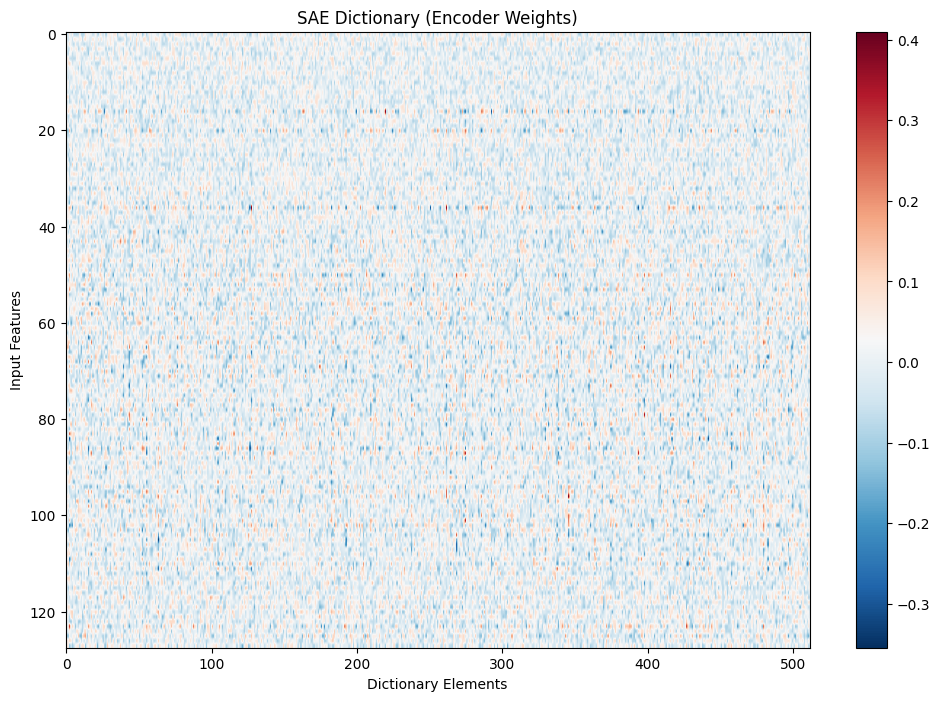

In [149]:
# Let's analyze the relationship between SAE activations and input features

# TODO(bschoen): Oh `imshow` is huge here!

# 1. Visualize the dictionary (encoder weights)
plt.figure(figsize=(12, 8))
plt.imshow(dictionary.cpu().T, aspect='auto', cmap='RdBu_r')
plt.colorbar()
plt.title("SAE Dictionary (Encoder Weights)")
plt.xlabel("Dictionary Elements")
plt.ylabel("Input Features")
plt.show()

In [150]:
# 2. Find the most active neurons for each input
top_k = 5  # Number of top activations to consider
top_activations = torch.topk(sae_outputs.sae_activations, k=top_k, dim=1)

In [152]:
print(f'{sae_outputs.sae_activations.shape=}')
print(f'{top_activations.values.shape=}')

sae_outputs.sae_activations.shape=torch.Size([4, 512])
top_activations.values.shape=torch.Size([4, 5])


In [153]:
# ex: 51 and 410 show up a lot
top_activations

torch.return_types.topk(
values=tensor([[1.7268, 1.1695, 1.0367, 0.9833, 0.9481],
        [1.6192, 1.3688, 1.1490, 1.1105, 1.0024],
        [1.4596, 1.3458, 1.1869, 1.1132, 1.1099],
        [1.4411, 1.3632, 1.2692, 1.2314, 1.0829]], device='mps:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[ 51, 491,  38, 381, 481],
        [ 51,  38, 410, 499, 195],
        [ 38, 410, 381, 423,  51],
        [410,  51,  38, 195, 381]], device='mps:0'))

In [163]:
# 3. Analyze feature importance for each neuron
feature_importance = torch.abs(dictionary).sum(dim=1)
top_features = torch.topk(feature_importance, k=10)

print(f'{dictionary.shape=}')
print(f'{feature_importance.shape=}')
print(f'{top_features.values.shape=}')
print(f'{top_features.indices.shape=}')

top_features


dictionary.shape=torch.Size([512, 128])
feature_importance.shape=torch.Size([512])
top_features.values.shape=torch.Size([10])
top_features.indices.shape=torch.Size([10])


torch.return_types.topk(
values=tensor([10.4343, 10.0588, 10.0010,  9.7971,  9.4950,  9.4443,  9.4198,  9.4159,
         9.3229,  9.3187], device='mps:0'),
indices=tensor([274, 345,  55, 268,  63, 192,  43, 337, 482, 104], device='mps:0'))

In [165]:
print("\nTop 10 most important neurons:")
for i, (value, index) in enumerate(zip(top_features.values.tolist(), top_features.indices.tolist())):
    print(f"Neuron {index}:\t{value:.4f}")


Top 10 most important neurons:
Neuron 274:	10.4343
Neuron 345:	10.0588
Neuron 55:	10.0010
Neuron 268:	9.7971
Neuron 63:	9.4950
Neuron 192:	9.4443
Neuron 43:	9.4198
Neuron 337:	9.4159
Neuron 482:	9.3229
Neuron 104:	9.3187


In [160]:
top_features.values.tolist()

[10.434272766113281,
 10.058801651000977,
 10.001038551330566,
 9.797117233276367,
 9.494978904724121]

In [161]:
top_features.indices.tolist()

[274, 345, 55, 268, 63]

sae_activations.shape=torch.Size([512])


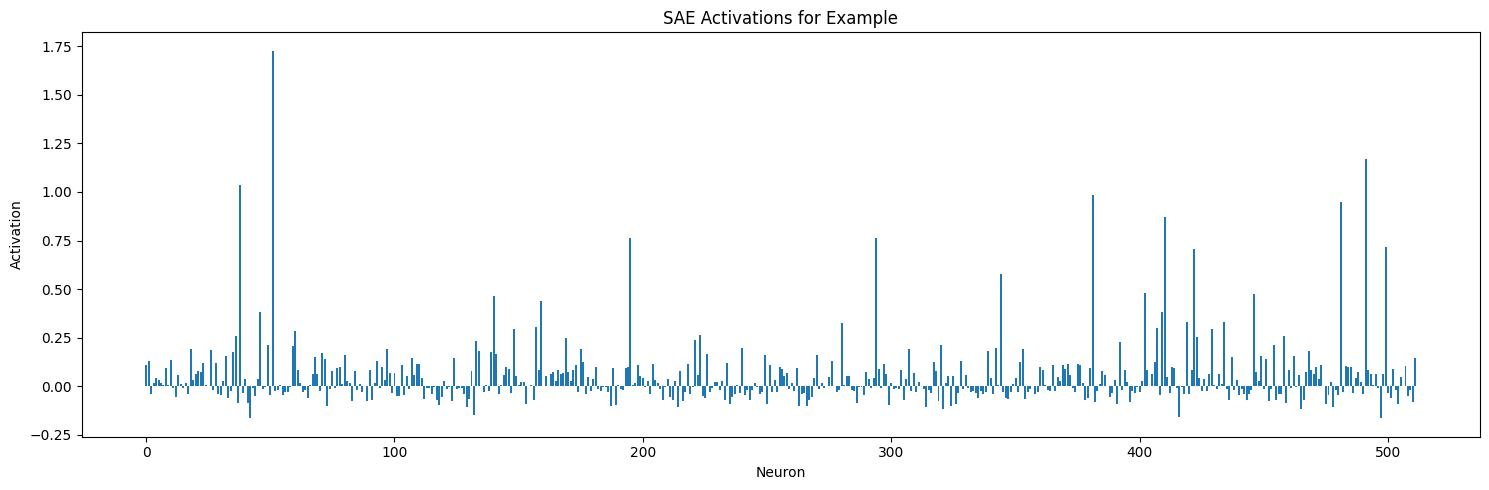

In [175]:
# 4. Visualize activations for a few examples

# first look at a single batch
sae_activations = sae_outputs.sae_activations[0].detach().cpu()

print(f'{sae_activations.shape=}')

plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)

# Look at a single batch
plt.bar(range(sae_activations.shape[0]), sae_activations)

plt.title(f"SAE Activations for Example")
plt.xlabel("Neuron")
plt.ylabel("Activation")
plt.tight_layout()
plt.show()

4

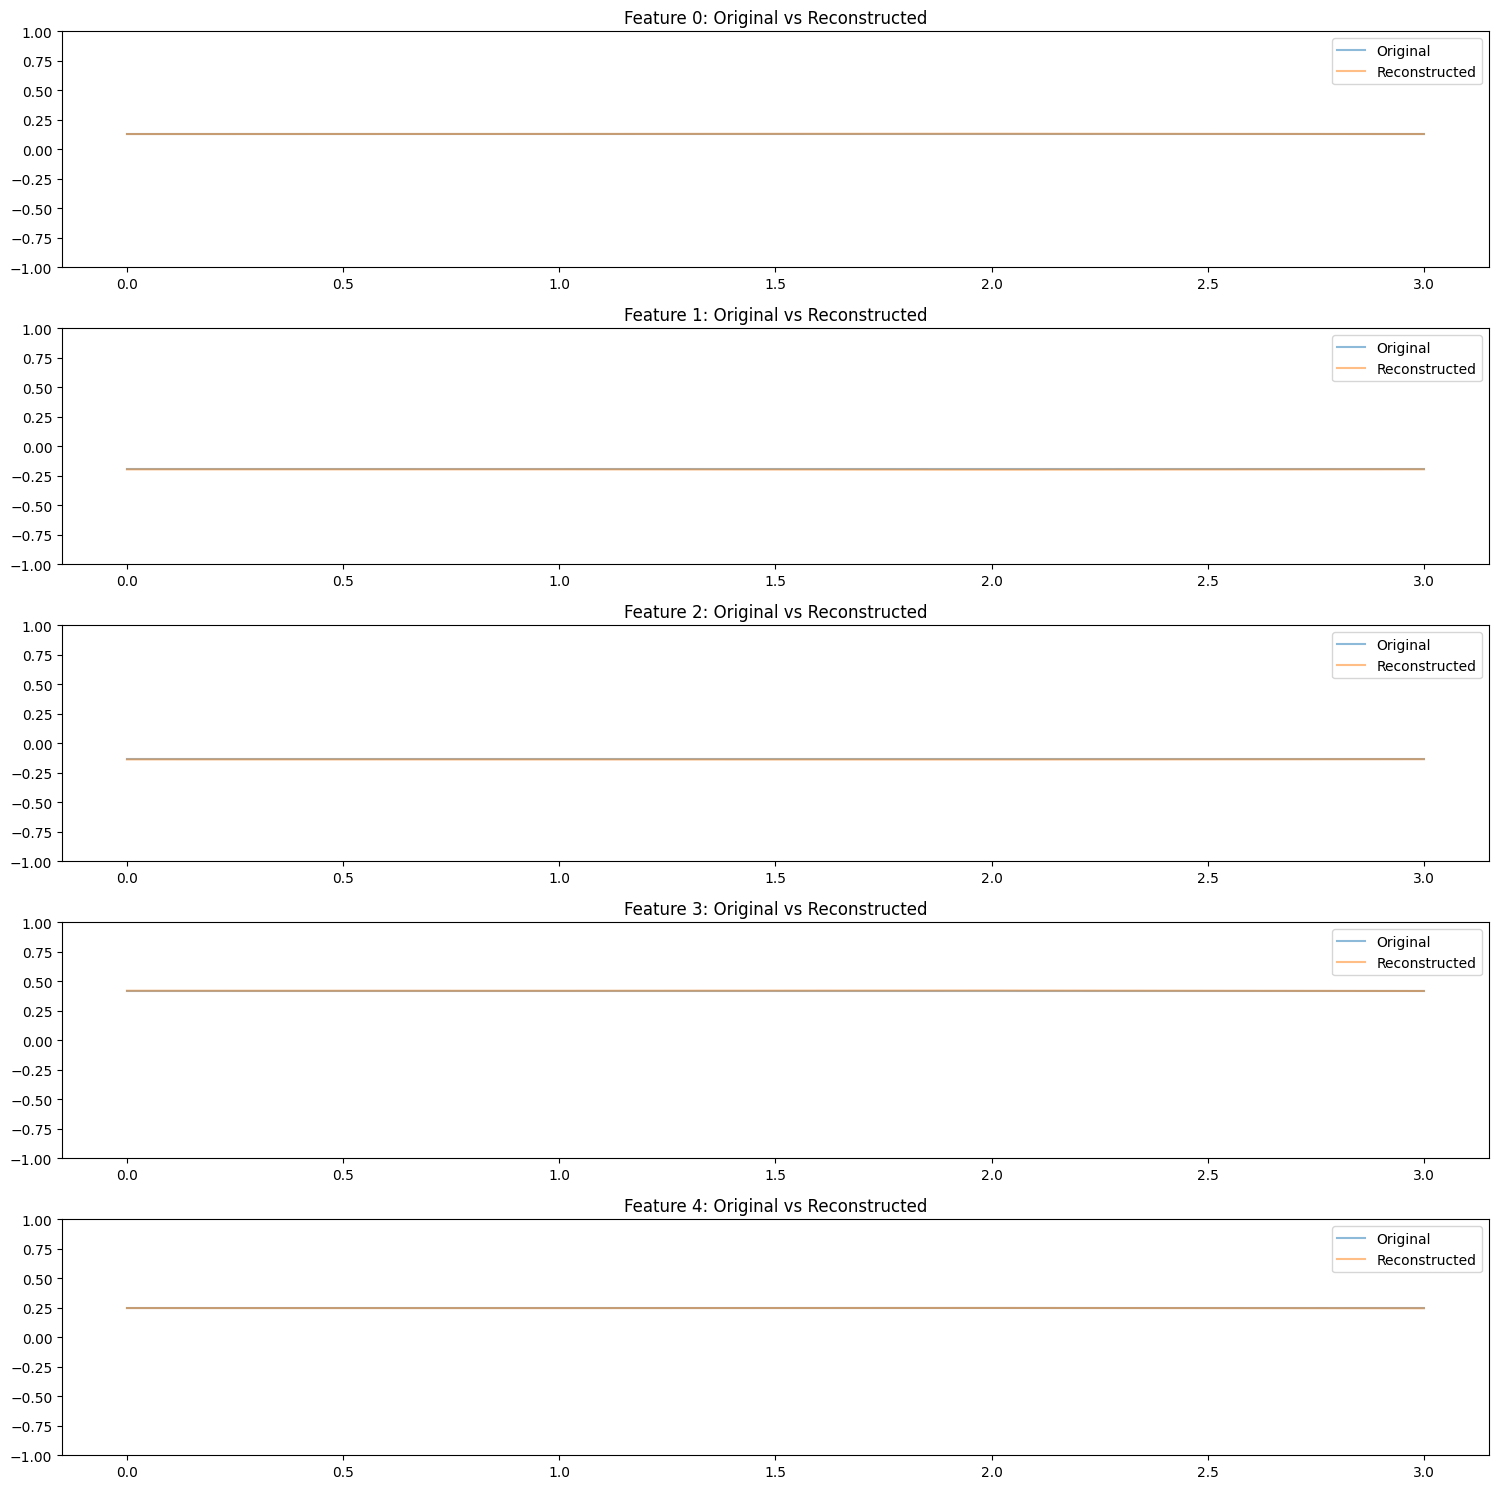

In [180]:

# 5. Reconstruct input features from SAE activations
#
# Take a single batch first
reconstructed_model_activations = sae_outputs.reconstructed_model_activations.detach().cpu()

# 6. Compare original and reconstructed features
num_features = 5

plt.figure(figsize=(15, 3 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.ylim(-1, 1)  # Set y-axis range from -1 to 1
    plt.plot(flattened_activations[:, i].cpu(), label='Original', alpha=0.5)
    plt.plot(reconstructed_model_activations[:, i], label='Reconstructed', alpha=0.5)
    plt.title(f"Feature {i}: Original vs Reconstructed")
    plt.legend()
plt.tight_layout()
plt.show()


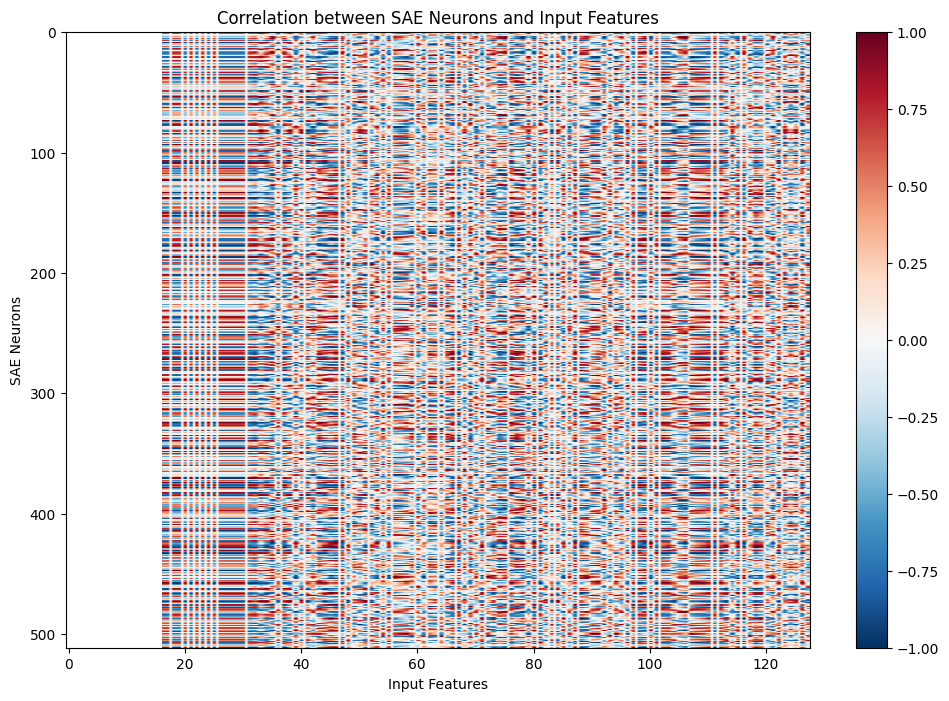

In [182]:
# 7. Correlation between SAE activations and input features
correlation_matrix = torch.corrcoef(torch.cat([sae_outputs.sae_activations, flattened_activations], dim=1).T)
num_neurons = sae_outputs.sae_activations.shape[1]
neuron_feature_correlation = correlation_matrix[:num_neurons, num_neurons:]

plt.figure(figsize=(12, 8))
plt.imshow(neuron_feature_correlation.detach().cpu(), aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Correlation between SAE Neurons and Input Features")
plt.xlabel("Input Features")
plt.ylabel("SAE Neurons")
plt.show()


explained_variance.item()=0.9997


tensor(0.0846, device='mps:0', grad_fn=<MeanBackward0>)

In [128]:
sae_outputs.sae_activations

tensor([[ 0.0172,  0.0374, -0.0049,  ..., -0.0247, -0.0385,  0.0506],
        [ 0.1662,  0.1229, -0.0017,  ..., -0.0917,  0.0055,  0.1449],
        [ 0.1652, -0.0602, -0.0342,  ..., -0.0196, -0.0149,  0.2168],
        [ 0.2462,  0.0558, -0.0212,  ...,  0.0448, -0.0335,  0.1834]],
       device='mps:0', grad_fn=<GeluBackward0>)

In [ ]:
# collect max activations


with torch.no_grad():

    # go through the training data again, but don't cycle, no reason to go through more than once
    for batch in tqdm.tqdm(train_loader):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # run through the model (with cache) to get the activations
        logits, cache = model.run_with_cache(tokens)

        # ex: torch.Size([4, 8, 16])
        activations = cache[hook_id]

        # ex: torch.Size([4, 128])
        flattened_activations = activations.reshape(activations.size(0), -1)

        # now the SAE model is given the *activations*
        encoded, decoded = sae_model(flattened_activations)

        sae_activations = encoded

        # sae_activations.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

        # max_activations = torch.max(encoded, dim=1)


        break

In [138]:
alpha = sae_model.encoder.weight @ flattened_activations[0]

print(f'{alpha.shape=}')

alpha.shape=torch.Size([512])


In [140]:
torch.mean(torch.abs(alpha))

tensor(0.4260, device='mps:0', grad_fn=<MeanBackward0>)

In [ ]:
sae_activations[0].shape

In [ ]:
8 * 16